In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [2]:
import glob
import os
import PIL
import time

from IPython import display

# Data

In [3]:
path_root = "C:/Users/Max/Documents/thesis_data"

In [4]:
batches = ImageDataGenerator().flow_from_directory(directory=path_root, color_mode = "rgb", 
                                                   target_size=(64,64), class_mode= "sparse", interpolation="bicubic", 
                                                   batch_size=40000)
imgs, labels = next(batches)
imgs.shape

Found 26548 images belonging to 11 classes.


(26548, 64, 64, 3)

In [5]:
batches.class_indices

{'BetterSurf': 0,
 'Eksor.A': 1,
 'Obfuscator.AFQ': 2,
 'Occamy.C': 3,
 'OnLineGames.CTB': 4,
 'Reveton.A': 5,
 'Sfone': 6,
 'VB.IL': 7,
 'Zbot': 8,
 'Zbot!CI': 9,
 'benign': 10}

In [6]:
num_classes = len(batches.class_indices)

In [7]:
testsize = 0.3
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=testsize)

In [8]:
trainsize = len(X_train)
testsize = len(X_test)

print(f"Size of training data: {trainsize} | Shape of training data {X_train.shape}")
print(f"Size of training data: {testsize}  | Shape of training data {X_test.shape}")
print(f"Shape of training labels {y_train.shape}")
print(f"Shape of training labels {y_test.shape}")

Size of training data: 18583 | Shape of training data (18583, 64, 64, 3)
Size of training data: 7965  | Shape of training data (7965, 64, 64, 3)
Shape of training labels (18583,)
Shape of training labels (7965,)


# Preparing models

In [9]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       20

In [10]:
discriminator = keras.Sequential(
    [
        
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same", input_shape=(64, 64, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
checkpoint_dir = 'C:/Users/Max/Documents/gan_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [13]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Now, we transfer the weights of discriminator except the last layer to a new model, add a dense layer with 128 units, and add another dense layer with 10 units and softmax activation.

In [14]:
disc = checkpoint.discriminator
    
new_model = Sequential()
for i in range(len(disc.layers) - 1):
    new_model.add(disc.layers[i])

for layer in new_model.layers:
    layers.trainable = False

new_model.add(Dense(128, activation = "relu"))
new_model.add(Dense(num_classes, activation = "softmax"))
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [15]:
# view the initialized weights and bias of the second last dense layer; weights are uniformly randomly generated 
# and biases are all zeroes by default
new_model.layers[-2].weights

[<tf.Variable 'dense_2/kernel:0' shape=(8192, 128) dtype=float32, numpy=
 array([[ 0.01892105,  0.0198104 , -0.02403479, ..., -0.01901391,
         -0.02608649,  0.01256012],
        [ 0.01671883, -0.00711049, -0.00052397, ...,  0.02013447,
          0.02014318,  0.02137754],
        [-0.00536334,  0.01742311, -0.00564838, ..., -0.00580176,
         -0.01741466,  0.00381699],
        ...,
        [ 0.00174974, -0.02175686, -0.01952494, ..., -0.0226622 ,
          0.01822391,  0.0148507 ],
        [ 0.02400888, -0.01569733,  0.00400726, ...,  0.02362526,
         -0.00042455,  0.02603223],
        [ 0.01606595, -0.02338173,  0.01653012, ..., -0.00268157,
          0.00223619, -0.0198178 ]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(128,) dtype=float32, numpy=
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [16]:
train_images = X_train.reshape((trainsize, 64,64,3))
train_images = train_images.astype('float32') / 255 # Was *255

(18583, 64, 64, 3)

In [17]:
test_images = X_test.reshape((testsize, 64,64,3))
test_images = test_images.astype('float32') / 255 # Was *255

In [54]:
print(train_images.shape)
print(test_images.shape)

(18583, 64, 64, 3)
(7965, 64, 64, 3)


In [55]:
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(18583, 64, 64, 3) (18583, 11) (7965, 64, 64, 3) (7965, 11)


In [19]:
new_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history1 = new_model.fit(train_images, train_labels, batch_size=100, epochs=7,
                        validation_data=(test_images, test_labels))

Epoch 1/7
186/186 [==============================] - 5s 19ms/step - loss: 0.3573 - accuracy: 0.8926 - val_loss: 0.2275 - val_accuracy: 0.9304
Epoch 2/7
186/186 [==============================] - 3s 18ms/step - loss: 0.1953 - accuracy: 0.9381 - val_loss: 0.1890 - val_accuracy: 0.9431
Epoch 3/7
186/186 [==============================] - 3s 18ms/step - loss: 0.1477 - accuracy: 0.9545 - val_loss: 0.1649 - val_accuracy: 0.9510
Epoch 4/7
186/186 [==============================] - 3s 18ms/step - loss: 0.1232 - accuracy: 0.9609 - val_loss: 0.1664 - val_accuracy: 0.9533
Epoch 5/7
186/186 [==============================] - 3s 18ms/step - loss: 0.1085 - accuracy: 0.9651 - val_loss: 0.1685 - val_accuracy: 0.9529
Epoch 6/7
186/186 [==============================] - 3s 18ms/step - loss: 0.0907 - accuracy: 0.9722 - val_loss: 0.1855 - val_accuracy: 0.9567
Epoch 7/7
186/186 [==============================] - 3s 18ms/step - loss: 0.0806 - accuracy: 0.9749 - val_loss: 0.1941 - val_accuracy: 0.9556


In [20]:
# unfreeze all layers 
for layer in new_model.layers:
    layer.trainable = True

#optimizer=new_model.optimizer
#optimizer.learning_rate=0.005
    
new_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history2 = new_model.fit(train_images, train_labels, batch_size=100, epochs=8,
                        validation_data=(test_images, test_labels)) 


Epoch 1/8
186/186 [==============================] - 4s 19ms/step - loss: 0.0828 - accuracy: 0.9744 - val_loss: 0.2004 - val_accuracy: 0.9587
Epoch 2/8
186/186 [==============================] - 3s 18ms/step - loss: 0.0784 - accuracy: 0.9755 - val_loss: 0.2366 - val_accuracy: 0.9537
Epoch 3/8
186/186 [==============================] - 3s 18ms/step - loss: 0.0750 - accuracy: 0.9762 - val_loss: 0.2217 - val_accuracy: 0.9543
Epoch 4/8
186/186 [==============================] - 3s 18ms/step - loss: 0.0797 - accuracy: 0.9757 - val_loss: 0.2260 - val_accuracy: 0.9554
Epoch 5/8
186/186 [==============================] - 3s 18ms/step - loss: 0.0581 - accuracy: 0.9815 - val_loss: 0.2403 - val_accuracy: 0.9579
Epoch 6/8
186/186 [==============================] - 3s 18ms/step - loss: 0.0515 - accuracy: 0.9838 - val_loss: 0.2277 - val_accuracy: 0.9599
Epoch 7/8
186/186 [==============================] - 3s 18ms/step - loss: 0.0550 - accuracy: 0.9822 - val_loss: 0.3208 - val_accuracy: 0.9520
Epoch 

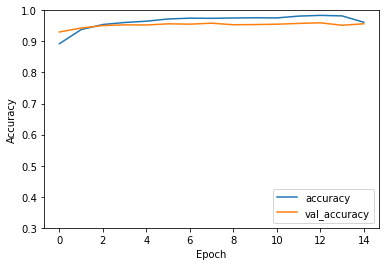

In [21]:
accuracy = history1.history['accuracy'] + history2.history['accuracy']
val_accuracy = history1.history['val_accuracy'] + history2.history['val_accuracy']

plt.figure()
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')
plt.show()

We can see that, using the tuned discriminator model, both training accuracy and testing are approximately 0.94 after 15 epochs.

actual label: 10


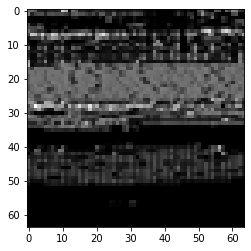

[[0.0000000e+00 7.3927625e-34 0.0000000e+00 4.7799569e-20 1.0156857e-30
  1.7487078e-28 9.5230117e-31 4.6741572e-31 2.9925049e-31 5.4759914e-25
  1.0000000e+00]]
-----------------------------------------------------------------------
prediction: 10


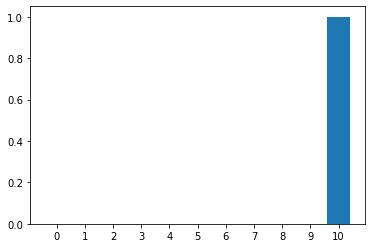

In [22]:
# demonstration: predict the ith test digit
i = np.random.randint(0, testsize)

# show the actual ith digit
print('actual label:', np.argmax(test_labels[i]))
plt.figure()
plt.imshow(test_images[i,:,:,0], cmap='gray')
plt.show()

# predict
prediction = new_model.predict(test_images[i].reshape(1,64,64,3))

# get probability distribution and classification of the test digit
print(prediction)
print("-----------------------------------------------------------------------")
print('prediction:', np.argmax(prediction))

# draw the barplot
plt.figure()
plt.bar(np.arange(0,11).astype('str'), prediction[0,:])
plt.show()

# Analyse performance

In [23]:
from sklearn import metrics
import pandas as pd
import seaborn as sns

In [24]:
y_pred = np.argmax(new_model.predict(test_images), axis=-1)
true_labels = test_labels.argmax(axis=1)

In [25]:
y_pred

array([10,  0, 10, ..., 10,  0, 10], dtype=int64)

In [26]:
y_test2 = np.argmax(test_labels, axis=1)
y_test2

array([10,  0, 10, ..., 10,  0, 10], dtype=int64)

In [27]:
c_matrix = metrics.confusion_matrix(y_test2, y_pred)

In [28]:
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

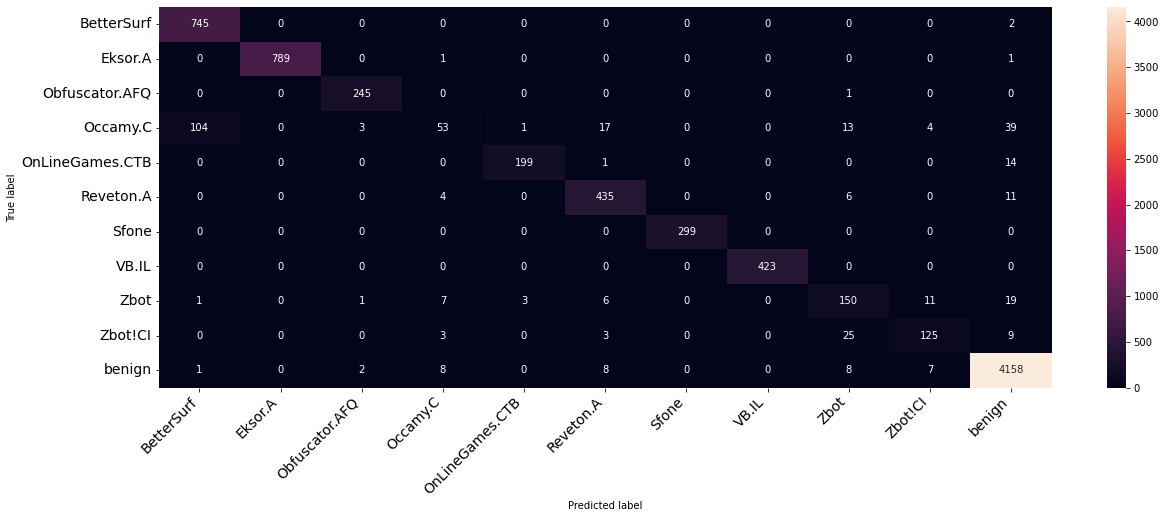

In [29]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)

# Binary classification

In [30]:
from sklearn.metrics import f1_score, matthews_corrcoef, accuracy_score
from prettytable import PrettyTable, MSWORD_FRIENDLY

In [31]:
y_predbin = [] 
y_truebin = []
for count, value in enumerate(y_test2):
    if y_test2[count] in range(10): # range(10) is 0 to 9
        y_truebin.append(0)
    else: y_truebin.append(1)
    
    if y_pred[count] in range(10):
        y_predbin.append(0)
    else: y_predbin.append(1)
    
    continue
print(len(y_truebin))
print(len(y_predbin))

7965
7965


In [32]:
c_matrix_bin = metrics.confusion_matrix(y_truebin, y_predbin)

In [33]:
def confusion_matrix_bin(confusion_matrix, class_names_bin, figsize = (5,2), fontsize=7):
   
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names_bin, columns=class_names_bin, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

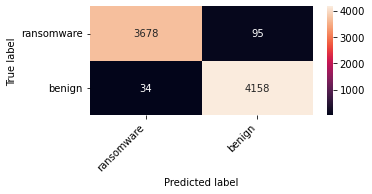

In [34]:
class_names_bin= ("ransomware", "benign")
confusion_matrix(c_matrix_bin, class_names_bin, figsize = (5,2), fontsize=10)

**True Positive Rate**

In [47]:
TPR = c_matrix_bin[0,0]/(c_matrix_bin[0,0] + c_matrix_bin[0,1]) #True Positive Rate

**Accuracy**

In [48]:
ACC = accuracy_score(y_truebin, y_predbin) # Accuracy

**F1 Score**

In [49]:
F1 = f1_score(y_truebin, y_predbin, labels=0) # F1 Score

**Matthews Correlation Coefficient**

In [50]:
MCC = matthews_corrcoef(y_truebin, y_predbin) # Matthews Correlation Coefficient

**Show Performance of CNN**

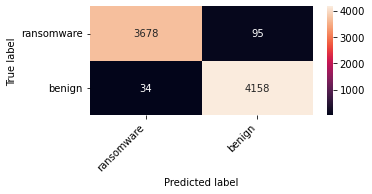

In [51]:
confusion_matrix(c_matrix_bin, class_names_bin, figsize = (5,2), fontsize=10)

In [52]:
t = PrettyTable(['Metric', 'Performance'])
t.add_row(['True Positive Rate', round(TPR,4)])
t.add_row(['Accuracy', round(ACC,4)])
t.add_row(['F1 Score', round(F1,4)])
t.add_row(['Matthews Correlation Coefficient', round(MCC,4)])
t.header = True
t.align = "l"
t.title = "Performance of GAN"
print(t)

+------------------------------------------------+
|               Performance of GAN               |
+----------------------------------+-------------+
| Metric                           | Performance |
+----------------------------------+-------------+
| True Positive Rate               | 0.9748      |
| Accuracy                         | 0.9838      |
| F1 Score                         | 0.9847      |
| Matthews Correlation Coefficient | 0.9676      |
+----------------------------------+-------------+


# NOT NECESSARY CODE

**Generate new digits and perform classification on them using our model**

In [41]:
noi = tf.random.normal([1, 100])
sample = checkpoint.generator(noi, training=False)
fig = plt.figure()
plt.imshow(sample[0, :, :, 0], cmap='gray')

ValueError: Input 0 of layer generator is incompatible with the layer: expected axis -1 of input shape to have value 128 but received input with shape (1, 100)

In [ ]:
new_sample = sample[0, :, :, 0].numpy().reshape(1,28,28,1)
new_prediction = new_model.predict(new_sample)

# get probability distribution and classification of the test digit
print(new_prediction)
print('prediction:', np.argmax(new_prediction))

# draw the barplot
plt.figure()
plt.bar(np.arange(0,10).astype('str'), new_prediction[0,:])
plt.show()

In [ ]:
# we can save the numpy array of appropriately generated digits as .npy file,
# which could be used for further training
np.save('generated_numpy.npy', sample[0, :, :, 0].numpy())

In [ ]:
# upload the saved numpy array
arr = np.load('generated_numpy.npy')
arr